In [1]:
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import jax
import jax.numpy as jnp
from scipy.stats import qmc

os.chdir('/mnt/home/sliu1/normalizing_flows')
from qmc_flow.models.tqmc import TransportQMC
from qmc_flow.targets import StanModel, Gaussian
from qmc_flow.utils import get_effective_sample_size, get_moments
rootdir = '/mnt/home/sliu1/ceph/normalizing_flows/qmc_flow'

MACHINE_EPSILON = np.finfo(np.float64).eps


/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <



Without IS is better: arK, arma, bones, garch, lotka-volterra, Mt, normal-mixture, rosenbrock, wells

IS is eventually better: arK, dogs, hmm, M0, nes_logit, radon, sesame, 

similar: gp_regrS

no results: eight-schools, onecomp, pkpd

In [253]:
color_list = {'mc': '#1c82b9', 'rqmc': 'orange', 'mc_IS': 'red', 'rqmc_IS': 'blue'}
date = '2024-09-25'
ntrain = 2**6
max_m = 9
m_list = np.arange(3, max_m + 1)
def make_plot(name, num_composition, max_deg, max_iter, legend=False, saveplot=False):
    path = os.path.join(rootdir, date, name)
    filename = os.path.join(path, f'mse_n_{ntrain}_comp_{num_composition}_deg_{max_deg}_lbfgs_iter_{max_iter}_lr_1.0.pkl')

    with open(filename, 'rb') as f:
        results = pickle.load(f)
    d = len(results['model_params']['best_params'][0]['b'])
    mse = results['test_results']['mse']
    mse = pd.DataFrame(mse).T.reset_index(names=['sampler', 'm', 'seed'])
    mse = mse.loc[mse['m'] <= max_m]
    mse.set_index(['sampler', 'm'], inplace=True)
    # mse_IS = results['test_results']['mse_IS']
    # mse_IS = pd.DataFrame(mse_IS).T.reset_index(names=['sampler', 'm', 'seed'])
    # mse_IS['sampler'] = mse_IS['sampler'] + '_IS'
    # df = pd.concat([mse, mse_IS], axis=0)
    titles = [r'$x_1$', r'$x_d$', r'$x_{1}^2$', r'$x_{d}^2$']
    sns.set_theme(context='talk', style='whitegrid')
    fig, ax = plt.subplots(1, 4, figsize=(10, 2.3), sharey=True)
    for j, col_idx in enumerate([0, d-1, d, 2*d-1]):
        sns.pointplot(ax=ax[j], data=mse, x='m', y=col_idx, hue='sampler', ls='', palette=color_list, capsize=0.1, markers=['.', '*'])
        ax[j].set_title(titles[j])
        ax[j].set_ylabel('MSE')

        l1 = 1 / 2**m_list
        l1 = l1 / l1[0] * mse.loc[mse.index == ('mc', 3)][col_idx].mean()
        l2 = 1 / (4**m_list)
        l2 = l2 / l2[0] * mse.loc[mse.index == ('rqmc', 3)][col_idx].mean()
        ax[j].plot(m_list - 3, l1, ls='--', c='gray')
        ax[j].plot(m_list - 3, l2, ls=':', c='gray')
        ax[j].set_xticks(np.arange(0, max_m -2, 2))
        ax[j].set_xticklabels([r"$2^{{{:.0f}}}$".format(m) for m in np.arange(3, max_m + 1, 2)])
        ax[j].set_xlabel('n')
        ax[j].legend().remove()
        if j == 0:
            ax[j].annotate(r'$n^{-1}$', (m_list[-1]-3.5, l1[-1]), fontsize=13)
            ax[j].annotate(r'$n^{-2}$', (m_list[-1]-3.5, l2[-1]), fontsize=13)
    if legend:
        handles, labels = ax[j].get_legend_handles_labels()
        labels = ['MC', 'RQMC']
        lgd = fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.45), ncol=2)
    plt.yscale('log', base=2)
    plt.suptitle(name, y=.95)
    plt.subplots_adjust(top=0.75)
    # plt.tight_layout(rect=[0, 0, 1, 0.9])
    if saveplot:
        if legend:
            plt.savefig(f'qmc_flow/plots/2024-09-28/moments_mse_{name}_ntrain_{ntrain}_comp_{num_composition}_deg_{max_deg}_iter_{max_iter}.pdf', bbox_inches='tight', bbox_extra_artists=(lgd, ))
        else:
            plt.savefig(f'qmc_flow/plots/2024-09-28/moments_mse_{name}_ntrain_{ntrain}_comp_{num_composition}_deg_{max_deg}_iter_{max_iter}.pdf', bbox_inches='tight')


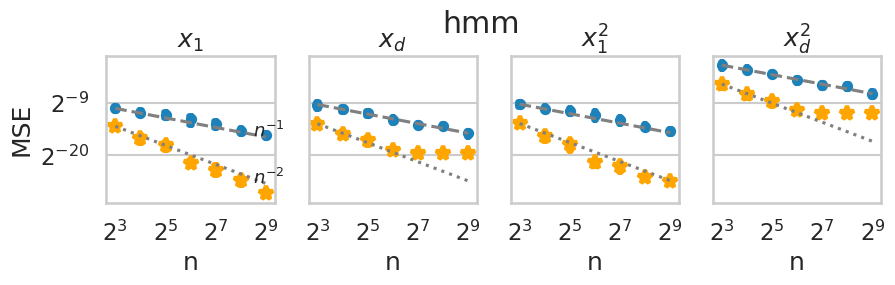

In [280]:
name = 'hmm'
num_composition = 3
max_deg = 3
max_iter = 400
make_plot(name, num_composition, max_deg, max_iter, legend=False, saveplot=True)

In [49]:
def make_plot(name, saveplot=False, showplot=False):
    moments_1 = None
    moments_2 = None
    num_composition = 5
    max_deg = 7
    max_iter = 400
    ntrain = 64
    date = '2024-09-14'
    path = os.path.join(rootdir, date, name, 'mse')
    for seed in range(50):
        filename = os.path.join(path, f'ntrain_{ntrain}_comp_{num_composition}_deg_{max_deg}_iter_{max_iter}_seed_{seed}.pkl')
        if not os.path.exists(filename):
            continue
        with open(filename, 'rb') as f:
            results = pickle.load(f)
        if moments_1 is None:
            moments_1 = results['moments_1']
            moments_2 = results['moments_2']
        else:
            moments_1 = pd.concat([moments_1, results['moments_1']])
            moments_2 = pd.concat([moments_2, results['moments_2']])
    stds_1 = moments_1.groupby(['m', 'sampler']).std()
    stds_2 = moments_2.groupby(['m', 'sampler']).std()
    d = stds_1.shape[1] - 1
    color_list = {'mc': 'red', 'rqmc': 'blue'}
    sns.set_theme(context='talk', style='darkgrid', font_scale=1.)
    stds = stds_1
    m_list = np.arange(3, 16)
    fig, ax = plt.subplots(1, d, figsize=(3 * d, 2.5), sharey=True)
    for var_idx in range(d):
        sns.pointplot(ax=ax[var_idx], data=stds, x='m', y=var_idx, hue='sampler', markers=['.', '*'], palette=color_list, linestyles='')
        
        l1 = 1 / np.sqrt(2**m_list)
        l1 = l1 / l1[0] * stds.loc[stds.index == (3, 'mc')][var_idx].item()
        l2 = 1 / (2**m_list)
        l2 = l2 / l2[0] * stds.loc[stds.index == (3, 'rqmc')][var_idx].item()
        ax[var_idx].plot(m_list - 3, l1, ls='--', c='gray')
        ax[var_idx].plot(m_list - 3, l2, ls=':', c='gray')
        ax[var_idx].set_yscale('log', base=2)
        if var_idx > 0:
            ax[var_idx].legend().remove()
        else:
            handles, labels = ax[var_idx].get_legend_handles_labels()
            labels = ['MC', 'RQMC']
            ax[var_idx].legend(handles, labels, title='', frameon=False, loc='lower left')

        ax[var_idx].set_xticks(np.arange(0, 13, 3))
        ax[var_idx].set_xticklabels([r"$2^{{{:.0f}}}$".format(m) for m in np.arange(3, 16, 3)])
        ax[var_idx].set_xlabel('n')
        ax[var_idx].set_title(f'$x_{var_idx + 1}$')
        ax[var_idx].set_ylabel('Std. Err.')
        fig.suptitle(name, y=1.1)
    if saveplot:
        plt.savefig(f'qmc_flow/plots/2024-09-16/moment1_std_{name}_ntrain_{ntrain}_comp_{num_composition}_deg_{max_deg}_iter_{max_iter}.pdf', bbox_inches='tight')
    if showplot:
        plt.show()
    else:
        plt.close()

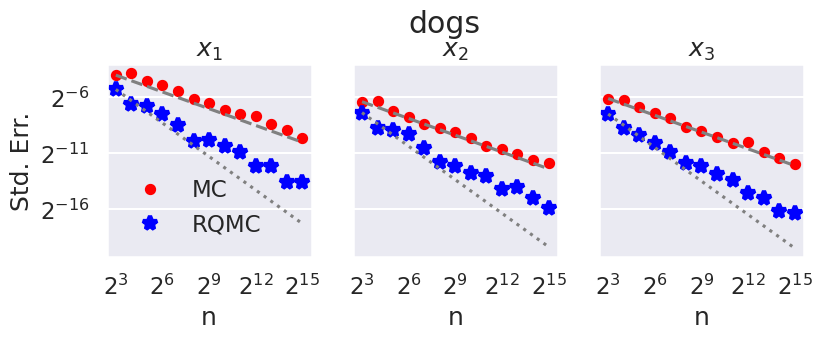

In [41]:
make_plot('dogs', saveplot=False, showplot=True)

In [50]:
for name in ['arK', 'bones', 'dogs', 'eight-schools', 'garch', 'gp_regr', 'hmm', 'logistic', 
             'lotka-volterra', 'M0', 'Mt', 'nes_logit', 'normal-mixture', 'pilots', 'radon', 
              'rosenbrock', 'sesame', 'wells']:
    try:
        make_plot(name, True, False)
    except:
        print(name)
        continue

bones


Check: arK, garch, eight-schools